# Reducing the number of initial features to select
> Can we use univariate feature prediction to eliminate useless features?

- toc: true 
- badges: true
- comments: true
- categories: [ranking features, vespa, feature selection, model selection]

In [1]:
# hide
%load_ext autoreload
%autoreload 2

## Load data collected from Vespa

The dataset used here were created by collecting ranking features from Vespa associated with the labelled data released by the round 3 of the TREC-CORD competition.

In [14]:
#hide
from pandas import read_msgpack

vespa_cord19 = read_msgpack("data/2020-05-27-subset-selection/training_features.msg")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
vespa_cord19.to_csv("data/2020-05-27-subset-selection/training_features.csv", index=False)

In [3]:
vespa_cord19.head(2)

,topic_id,iteration,cord_uid,relevancy,query,query-rewrite,query-vector,question,narrative,fieldMatch(abstract),...,fieldLength(abstract),fieldLength(body_text),fieldLength(title),freshness(timestamp),nativeRank(abstract),nativeRank(abstract_t5),nativeRank(title),rawScore(specter_embedding),rawScore(abstract_embedding),rawScore(title_embedding)
0,1,0.5,010vptx3,2,coronavirus origin,coronavirus origin origin COVID-19 information...,"(0.28812721371650696, 1.558979868888855, 0.481...",what is the origin of COVID-19,seeking range of information about the SARS-Co...,0.111406,...,0,0,0,0,0,0,0,0,0,0
1,1,2.0,p0kv1pht,1,coronavirus origin,coronavirus origin origin COVID-19 information...,"(0.28812721371650696, 1.558979868888855, 0.481...",what is the origin of COVID-19,seeking range of information about the SARS-Co...,0.094629,...,0,0,0,0,0,0,0,0,0,0


## Ranking features available

There are 163 ranking features available. 

In [4]:
features = [
    x for x in list(vespa_cord19.columns) if x not in [
        'topic_id', 'iteration', 'cord_uid', 'relevancy', 'binary_relevance', 'query', 
        'query-rewrite', 'query-vector', 'question', 'narrative'
    ]
]
print(len(features))

163


In [5]:
features

['fieldMatch(abstract)',
 'fieldMatch(abstract).absoluteOccurrence',
 'fieldMatch(abstract).absoluteProximity',
 'fieldMatch(abstract).completeness',
 'fieldMatch(abstract).degradedMatches',
 'fieldMatch(abstract).earliness',
 'fieldMatch(abstract).fieldCompleteness',
 'fieldMatch(abstract).gapLength',
 'fieldMatch(abstract).gaps',
 'fieldMatch(abstract).head',
 'fieldMatch(abstract).importance',
 'fieldMatch(abstract).longestSequence',
 'fieldMatch(abstract).longestSequenceRatio',
 'fieldMatch(abstract).matches',
 'fieldMatch(abstract).occurrence',
 'fieldMatch(abstract).orderness',
 'fieldMatch(abstract).outOfOrder',
 'fieldMatch(abstract).proximity',
 'fieldMatch(abstract).queryCompleteness',
 'fieldMatch(abstract).relatedness',
 'fieldMatch(abstract).segmentDistance',
 'fieldMatch(abstract).segmentProximity',
 'fieldMatch(abstract).segments',
 'fieldMatch(abstract).significance',
 'fieldMatch(abstract).significantOccurrence',
 'fieldMatch(abstract).tail',
 'fieldMatch(abstract).unw

## Simplify target label

The original labelled data has three types of label: 0, 1 and 2. To simplify we will consider just two labels here. The document is either relevant (label = 1) or irrelevant (label = 0)

In [6]:
vespa_cord19["binary_relevance"] = vespa_cord19.apply(lambda row: 1 if row["relevancy"] > 0 else 0, axis=1)
vespa_cord19[['relevancy', 'binary_relevance']].head()

,relevancy,binary_relevance
0,2,1
1,1,1
2,2,1
3,0,0
4,0,0


## Model

We are going to fit logistic regressions with the objective of maximizing the log probability of the observed outcome.

In [7]:
from sklearn.linear_model import LogisticRegression
from statistics import mean

def compute_mean_realize_log_prob(model, X, Y):
    return mean([x[int(y)] for x, y in zip(model.predict_log_proba(X), Y)])
    
def fit_logistic_reg(X, Y):
    model = LogisticRegression(penalty='none', fit_intercept=True)
    model.fit(X, Y)
    realized_log_prob = compute_mean_realize_log_prob(model, X, Y)
    return realized_log_prob

## Subset selection routine

Below we run the subset selection algorithm with only one feature.

In [8]:
import itertools
import pandas as pd
from tqdm import tnrange, tqdm_notebook #Importing tqdm for the progress bar
from tqdm.notebook import trange

log_probs, feature_list = [], []
numb_features = []
max_number_features = min(1, len(features))

data = vespa_cord19
Y = data.binary_relevance
X = data[features]

for k in range(1,max_number_features + 1):
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_logistic_reg(X[list(combo)],Y)   
        log_probs.append(tmp_result)                   
        feature_list.append(combo)
        numb_features.append(len(combo))   


#Store in DataFrame
df = pd.DataFrame(
    {
        'numb_features': numb_features,
        'log_probs': log_probs,
        'features':feature_list
    }
)

## Analyze results

### fine-grained results

In [9]:
df

,numb_features,log_probs,features
0,1,-0.553448,"(fieldMatch(abstract),)"
1,1,-0.568826,"(fieldMatch(abstract).absoluteOccurrence,)"
2,1,-0.570800,"(fieldMatch(abstract).absoluteProximity,)"
3,1,-0.536799,"(fieldMatch(abstract).completeness,)"
4,1,-0.571269,"(fieldMatch(abstract).degradedMatches,)"
...,...,...,...
158,1,-0.571269,"(nativeRank(abstract_t5),)"
159,1,-0.571269,"(nativeRank(title),)"
160,1,-0.571269,"(rawScore(specter_embedding),)"
161,1,-0.571269,"(rawScore(abstract_embedding),)"


### Plot average results across data samples

In [10]:
df['max_log_probs'] = df.groupby('numb_features')['log_probs'].transform(max)
df

,numb_features,log_probs,features,max_log_probs
0,1,-0.553448,"(fieldMatch(abstract),)",-0.535476
1,1,-0.568826,"(fieldMatch(abstract).absoluteOccurrence,)",-0.535476
2,1,-0.570800,"(fieldMatch(abstract).absoluteProximity,)",-0.535476
3,1,-0.536799,"(fieldMatch(abstract).completeness,)",-0.535476
4,1,-0.571269,"(fieldMatch(abstract).degradedMatches,)",-0.535476
...,...,...,...,...
158,1,-0.571269,"(nativeRank(abstract_t5),)",-0.535476
159,1,-0.571269,"(nativeRank(title),)",-0.535476
160,1,-0.571269,"(rawScore(specter_embedding),)",-0.535476
161,1,-0.571269,"(rawScore(abstract_embedding),)",-0.535476


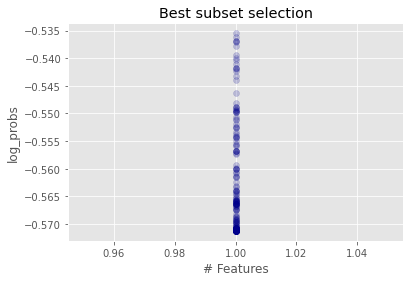

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.scatter(df.numb_features,df.log_probs, alpha = .2, color = 'darkblue')
plt.xlabel('# Features')
plt.ylabel('log_probs')
plt.title('Best subset selection')
plt.plot(df.numb_features,df.max_log_probs, color = 'r', label = 'Best subset')

plt.show()

### Display the best features for each model size

In [12]:
df_max = df.sort_values('log_probs', ascending=False)

In [13]:
for f in df_max.features:
    print(f)

('fieldMatch(abstract).significance',)
('fieldMatch(abstract).importance',)
('fieldMatch(abstract).completeness',)
('fieldMatch(abstract).queryCompleteness',)
('fieldMatch(abstract).weight',)
('bm25(abstract)',)
('textSimilarity(abstract).queryCoverage',)
('bm25(title)',)
('fieldMatch(title).significance',)
('fieldMatch(title).importance',)
('fieldMatch(title).completeness',)
('fieldMatch(title).weight',)
('fieldMatch(title).queryCompleteness',)
('textSimilarity(title).queryCoverage',)
('fieldMatch(abstract).matches',)
('fieldMatch(title).matches',)
('fieldMatch(title)',)
('nativeRank',)
('nativeProximity',)
('fieldMatch(abstract_t5).significance',)
('nativeFieldMatch',)
('fieldMatch(abstract_t5).importance',)
('fieldMatch(abstract).segments',)
('bm25(abstract_t5)',)
('fieldMatch(abstract_t5).completeness',)
('fieldMatch(abstract_t5).queryCompleteness',)
('fieldMatch(abstract_t5).weight',)
('textSimilarity(title).fieldCoverage',)
('fieldMatch(title).occurrence',)
('fieldMatch(title).fi

## Conclusion

Using the predicting performance of individual features does not seem a good approach to eliminate features from a grid search by greedy algorithms. The reason is that many features that perform poorly when considered in isolation would shine when combined with other complementary features.